# Simple quadratic convex problems

@Author: Ettore Biondi - ebiondi@caltech.edu

## Instantiation of vectors and operator
For testing the library we will be using a discretized version of the following operator:
\begin{align}
y = \frac{d^2f(x)}{dx^2},
\end{align}
in which we simply compute the second-order derivative of a function $f(x)$. 

#### Importing necessary libraries

In [1]:
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : True,
    'figure.figsize' : (6, 4),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
N = 200  # Number of points of the function f(x)
dx = 1/N  # Sampling of the function

# The stencil used is simply: (f(ix-1)-2f(ix)+f(ix+1))/(dx*dx)
D2 = np.zeros((N, N), dtype=np.float64)
np.fill_diagonal(D2, -2 / (dx * dx))
np.fill_diagonal(D2[1:], 1 / (dx * dx))
np.fill_diagonal(D2[:,1:], 1 / (dx * dx))

f = o.VectorNumpy((N, 1)).zero()
y = f.clone()

D2 = o.Matrix(o.VectorNumpy(D2), f, y)

Before we set any inversion problem, we study some of the properties of the constructed operator Deriv2Op.

In [3]:
# Verifying operator adjointness through dot-product test
D2.dotTest(verbose=True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.004538536071777344 seconds
Applying adjoint operator add=False
 Runs in: 0.0005342960357666016 seconds
Dot products add=False: domain=2.381674e+05 range=2.381674e+05 
Absolute error: 5.820766e-11
Relative error: 2.443982e-16 

Applying forward operator add=True
 Runs in: 7.200241088867188e-05 seconds
Applying adjoint operator add=True
 Runs in: 0.00022292137145996094 seconds
Dot products add=True: domain=4.763347e+05 range=4.763347e+05 
Absolute error: 1.164153e-10
Relative error: 2.443982e-16 

-------------------------------------------------


Computing maximum and minimum eigenvalues of the operator using the power iteration method and compare them against the ones computed using numpy

In [4]:
egsOp = D2.powerMethod(verbose=False, eval_min=True, tol=1e-300)
egsNp, _ = np.linalg.eig(D2.matrix.getNdArray())
egsNp = egsNp[egsNp.argsort()[::-1]] #Sorting the eigenvalues
print("\nMaximum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[0], egsNp[-1]))
print(  "Minimum eigenvalue: %s (Power method), %s (NUMPY)" % (egsOp[1], egsNp[0]))


Maximum eigenvalue: -159990.22855475376 (Power method), -159990.2285552523 (NUMPY)
Minimum eigenvalue: -9.771445230813697 (Power method), -9.77144474784679 (NUMPY)


We can see that the matrix is negative definite. The small mismatch in the estimated eigenvalues is due to the dependence of the power method on the initial random eigenvector.

## Inversion tests
We will now focus our attention on inverting a function knowning its second-order derivative. In this case we will assume that $y$ is constant and equal to $1$. Therefore, we expect to obtain a parabola with positive curvature. Given the chosen boundary conditions we know that the matrix is invertible since all eigenvalues have the same sign and are different then zero.
We will solve the following objective functions using linear conjugate-gradient methods:
\begin{equation*}
\phi_1(\mathbf{f}) = \frac{1}{2}\|D_2\mathbf{f}-\mathbf{y}\|_2^2
\end{equation*}
and
\begin{equation*}
\phi_2(\mathbf{f}) = \frac{1}{2}\mathbf{f}^T D_2 \mathbf{f} - \mathbf{f}^{T} \mathbf{y},
\end{equation*}
where $D_2$ represents the discretized second-order derivative operator, while $\mathbf{f}$ and $\mathbf{y}$ are the discretized representations of $f$ and $y$, respectively.

In [5]:
y.set(1.) # y = 1
# Note that f = 0
Phi1 = o.LeastSquares(f.clone().zero(), y, D2)
Phi2 = o.LeastSquaresSymmetric(f.clone().zero(), y, D2)

### Instantiation of solver objects
First, we create two different solver object for solving the two inversion problem stated above.

In [6]:
# Create LCG solver
LCGsolver = o.CG(o.BasicStopper(niter=2000))
LCGsolver.setDefaults(save_obj=True)

# Create LCG solver for symmetric systems
SLCG = o.CGsym(o.BasicStopper(niter=2000))
SLCG.setDefaults(save_obj=True, save_model=True)

Secondly, we run the solvers to minimize the objective functions previously defined.

In [7]:
LCGsolver.run(Phi1, verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-50-53.913509/
##########################################################################################

iter = 0000, obj = 1.00000e+02, rnorm = 1.41e+01, gnorm = 5.66e+04, feval = 00002
iter = 0001, obj = 9.98000e+01, rnorm = 1.41e+01, gnorm = 4.66e+04, feval = 00004
iter = 0002, obj = 9.96483e+01, rnorm = 1.41e+01, gnorm = 4.20e+04, feval = 00006
iter = 0003, obj = 9.95208e+01, rnorm = 1.41e+01, gnorm = 3.90e+04, feval = 00008
iter = 0004, obj = 9.94086e+01, rnorm = 1.41e+01, gnorm = 3.69e+04, feval = 00010
iter = 0005, obj = 9.93072e+01, rnorm = 1.41e+01, gnorm = 3.52e+04, feval = 00012
iter = 0006, obj = 9.92139e+01, rnorm = 1.41e+01, gnorm = 3.39e+04, feval = 00014
iter = 0007, obj = 9.91271e+01, rnorm = 1.41e+01, gnorm = 3.28e+04, feval = 00016
iter = 0008, obj = 9.90455e+01, rnorm = 1.41e+01, gnorm = 3.18e+04, feval = 00

iter = 0121, obj = 9.40543e+01, rnorm = 1.37e+01, gnorm = 3.20e+04, feval = 00244
iter = 0122, obj = 9.39411e+01, rnorm = 1.37e+01, gnorm = 4.37e+04, feval = 00246
iter = 0123, obj = 9.37967e+01, rnorm = 1.37e+01, gnorm = 3.13e+04, feval = 00248
iter = 0124, obj = 9.37544e+01, rnorm = 1.37e+01, gnorm = 1.42e+04, feval = 00250
iter = 0125, obj = 9.37464e+01, rnorm = 1.37e+01, gnorm = 7.09e+03, feval = 00252
iter = 0126, obj = 9.37437e+01, rnorm = 1.37e+01, gnorm = 4.84e+03, feval = 00254
iter = 0127, obj = 9.37419e+01, rnorm = 1.37e+01, gnorm = 5.55e+03, feval = 00256
iter = 0128, obj = 9.37376e+01, rnorm = 1.37e+01, gnorm = 1.04e+04, feval = 00258
iter = 0129, obj = 9.37140e+01, rnorm = 1.37e+01, gnorm = 2.07e+04, feval = 00260
iter = 0130, obj = 9.36340e+01, rnorm = 1.37e+01, gnorm = 3.98e+04, feval = 00262
iter = 0131, obj = 9.34869e+01, rnorm = 1.37e+01, gnorm = 4.41e+04, feval = 00264
iter = 0132, obj = 9.33549e+01, rnorm = 1.37e+01, gnorm = 3.36e+04, feval = 00266
iter = 0133, obj

iter = 0298, obj = 4.98865e+01, rnorm = 9.99e+00, gnorm = 4.18e+05, feval = 00598
iter = 0299, obj = 3.35917e+01, rnorm = 8.20e+00, gnorm = 2.33e+05, feval = 00600
iter = 0300, obj = 1.97988e+01, rnorm = 6.29e+00, gnorm = 3.08e+05, feval = 00602
iter = 0301, obj = 9.29499e+00, rnorm = 4.31e+00, gnorm = 2.08e+05, feval = 00604
iter = 0302, obj = 7.40993e+00, rnorm = 3.85e+00, gnorm = 1.18e+05, feval = 00606
iter = 0303, obj = 6.99169e+00, rnorm = 3.74e+00, gnorm = 4.24e+04, feval = 00608
iter = 0304, obj = 6.12529e+00, rnorm = 3.50e+00, gnorm = 6.53e+04, feval = 00610
iter = 0305, obj = 5.84772e+00, rnorm = 3.42e+00, gnorm = 2.88e+04, feval = 00612
iter = 0306, obj = 5.73638e+00, rnorm = 3.39e+00, gnorm = 5.93e+04, feval = 00614
iter = 0307, obj = 5.32788e+00, rnorm = 3.26e+00, gnorm = 8.54e+04, feval = 00616
iter = 0308, obj = 2.75342e-01, rnorm = 7.42e-01, gnorm = 5.77e+04, feval = 00618
iter = 0309, obj = 1.46648e-01, rnorm = 5.42e-01, gnorm = 3.66e+04, feval = 00620
iter = 0310, obj

iter = 0485, obj = 2.74799e-18, rnorm = 2.34e-09, gnorm = 6.39e-05, feval = 00972
iter = 0486, obj = 2.24175e-18, rnorm = 2.12e-09, gnorm = 6.87e-05, feval = 00974
iter = 0487, obj = 1.78427e-18, rnorm = 1.89e-09, gnorm = 4.58e-05, feval = 00976
iter = 0488, obj = 1.72935e-18, rnorm = 1.86e-09, gnorm = 5.82e-06, feval = 00978
iter = 0489, obj = 1.72792e-18, rnorm = 1.86e-09, gnorm = 3.80e-06, feval = 00980
iter = 0490, obj = 1.72159e-18, rnorm = 1.86e-09, gnorm = 6.84e-06, feval = 00982
iter = 0491, obj = 1.71999e-18, rnorm = 1.85e-09, gnorm = 4.21e-06, feval = 00984
iter = 0492, obj = 1.71820e-18, rnorm = 1.85e-09, gnorm = 3.66e-06, feval = 00986
iter = 0493, obj = 1.71538e-18, rnorm = 1.85e-09, gnorm = 3.85e-06, feval = 00988
iter = 0494, obj = 1.71488e-18, rnorm = 1.85e-09, gnorm = 1.47e-06, feval = 00990
iter = 0495, obj = 1.71463e-18, rnorm = 1.85e-09, gnorm = 1.97e-06, feval = 00992
iter = 0496, obj = 1.71423e-18, rnorm = 1.85e-09, gnorm = 2.39e-06, feval = 00994
iter = 0497, obj

In [8]:
SLCG.run(Phi2, verbose=True)

##########################################################################################
            Symmetric CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-50-53.913671/
##########################################################################################

iter = 0000, obj = 0.00000e+00, rnorm = 1.41e+01, feval = 00001
iter = 0001, obj = 2.50000e-01, rnorm = 1.41e+02, feval = 00003
iter = 0002, obj = 4.95025e-01, rnorm = 1.39e+02, feval = 00005
iter = 0003, obj = 7.35125e-01, rnorm = 1.38e+02, feval = 00007
iter = 0004, obj = 9.70350e-01, rnorm = 1.36e+02, feval = 00009
iter = 0005, obj = 1.20075e+00, rnorm = 1.35e+02, feval = 00011
iter = 0006, obj = 1.42638e+00, rnorm = 1.34e+02, feval = 00013
iter = 0007, obj = 1.64728e+00, rnorm = 1.32e+02, feval = 00015
iter = 0008, obj = 1.86350e+00, rnorm = 1.31e+02, feval = 00017
iter = 0009, obj = 2.07510e+00, rnorm = 1.29e+02, feval = 00019
iter = 0010, obj = 2.28213e+00, rnorm = 1.28e+02, feval = 00021
iter = 0011, obj = 2

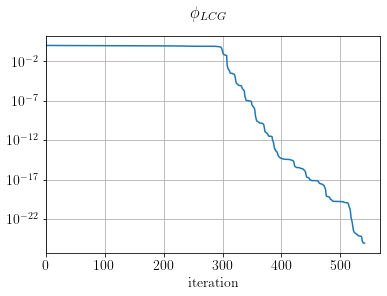

In [9]:
fig, ax = plt.subplots()
ax.semilogy((LCGsolver.obj / LCGsolver.obj[0]))
ax.set_xlabel("iteration")
ax.set_xlim(0)
plt.suptitle(r"$\phi_{LCG}$")
plt.show()

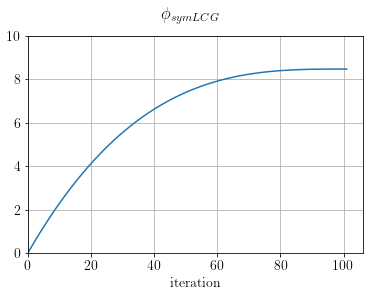

In [10]:
fig, ax = plt.subplots()
ax.plot(SLCG.obj)
ax.set_xlabel("iteration")
ax.set_xlim(0), ax.set_ylim(0,10)
plt.suptitle(r"$\phi_{symLCG}$")
plt.show()

Also, let's compare the two inverted functions with the analytical solution.
To find the solution for the continuous case we need three conditions:
\begin{equation}
\frac{d^2f(x)}{dx^2}=1,\\
f(x=0)=0,\\
f(x=x_f)=0.
\end{equation}
$x = 0$ and $x = x_f$ are not sampled and lay outside of the interval $\mathbf{x}$.

In [11]:
X = np.linspace(dx, N*dx, N)
alpha = 0.5
beta  = -(X[-1] + dx) * 0.5
gamma = 0.0
f_an  = alpha * X * X + beta * X + gamma

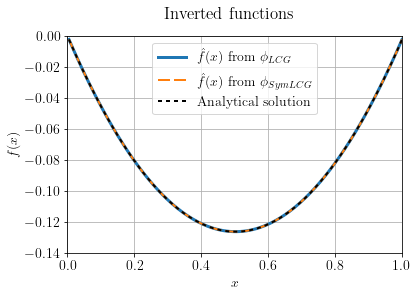

In [12]:
fig, ax = plt.subplots()

ax.plot(X, Phi1.model.plot(), linewidth=3, label="$\hat{f}(x)$ from $\phi_{LCG}$")
ax.plot(X, Phi2.model.plot(), linewidth=2, dashes=[6, 2], label="$\hat{f}(x)$ from $\phi_{SymLCG}$")
ax.plot(X, f_an, 'k', linewidth=2, dashes=[2, 2], label="Analytical solution")

ax.legend()
ax.set_xlabel(r"$x$"), ax.set_ylabel("$f(x)$")
ax.set_ylim(-0.14, 0), ax.set_xlim(0,1)

plt.suptitle("Inverted functions")
plt.show()

Now, let's try to solve both inversions using the inverse of $D_2$ as a preconditioner

In [13]:
# P = [D_2]^-1
P = o.Matrix(o.VectorNumpy(np.linalg.inv(D2.matrix.getNdArray())), f, y)

Phi1Prec = o.LeastSquares(f.clone(), y, D2, prec=P * P)
Phi2Prec = o.LeastSquaresSymmetric(f.clone(), y, D2, prec=P)

In [14]:
LCGsolver.setDefaults() # Re-setting default solver values
SLCG.setDefaults() # Re-setting default solver values

In [15]:
LCGsolver.run(Phi1Prec, verbose=True)

##########################################################################################
            Preconditioned CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-50-53.913509/
##########################################################################################

iter = 0000, obj = 1.00000e+02, rnorm = 1.41e+01, gnorm = 5.66e+04, feval = 00002
iter = 0001, obj = 1.26970e-22, rnorm = 1.59e-11, gnorm = 2.10e-06, feval = 00004
iter = 0002, obj = 7.95245e-47, rnorm = 1.26e-23, gnorm = 3.61e-19, feval = 00006
Objective function didn't reduce, will terminate solver:
	obj_new = 7.95245e-47	obj_cur = 7.95245e-47
##########################################################################################
            Preconditioned CG Solver end
##########################################################################################



In [16]:
SLCG.run(Phi2Prec, verbose=True)

##########################################################################################
            Preconditioned Symmetric CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-50-53.913671/
##########################################################################################

iter = 0000, obj = 0.00000e+00, rnorm = 1.41e+01, feval = 00001
iter = 0001, obj = 8.45875e+00, rnorm = 1.69e-11, feval = 00003
Objective function variation not monotonic, will terminate solver:
	obj_old=0.00000e+00	obj_cur=8.45875e+00	obj_new=8.45875e+00
##########################################################################################
            Preconditioned Symmetric CG Solver end
##########################################################################################



As expected, we converge to the global minimum in effectively one iteration.